# __Taylor-Butina clustering method__

## Requirements
!pip install pandas rdkit_pypi seaborn tqdm mols2grid

Normal rdkit instalation should suffice

In [18]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools, Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem import Descriptors
import seaborn as sns
from tqdm.auto import tqdm
import mols2grid

# Set progress bar for pandas execution
tqdm.pandas()

## __Define a function to prepare the database for clustering and conduct clustering__

**Database preparation includes:**

1. Calculate fingerprints for each molecule in mol_list
2. Calculate the similarity of every molecule to every othter molecule (all pairs)
3. Create a distance matrix containing 1-similarity for each pairwise similarity value
4. Assign a cluster id to each molecule

In [19]:
def butina_cluster(mol_list, cutoff=0.35):
    """
    Performs Butina clustering on a list of molecules.

    Parameters:
    - mol_list (list): A list of RDKit molecules.
    - cutoff (float): The clustering cutoff value. Default is 0.35.

    Returns:
    - cluster_id_list (list): A list of cluster IDs assigned to each molecule.

    """
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    for i in range(1, nfps):
        similarity = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dists.extend([1 - x for x in similarity])

    mol_clusters = Butina.ClusterData(dists, nfps, cutoff, isDistData=True)
    cluster_id_list = [0] * nfps

    for index, cluster in enumerate(mol_clusters, 1):
        for member in cluster:
            cluster_id_list[member] = index
    return cluster_id_list
    


In [20]:
# Reading in the database with a url
url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/dude_erk2_mk01.csv"
df = pd.read_csv(url)   
df.head()


Unnamed: 0                                             SMILES      ID  \
0           0  Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...  168691   
1           1  C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...   86358   
2           2  Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...  575087   
3           3  Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...  575065   
4           4  Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...  575047   

   is_active  
0          1  
1          1  
2          1  
3          1  
4          1

In [21]:
#The datanase contains smiles, mol ID and if the molecule is active
#df.dtypes # Data types of each column e.g. object, int64, float64
#df.columns # Names of each column
#df.describe() # Summary statistics
#len(df.ID.unique()) # Number of unique molecules - Non-duplicates

In [ ]:
# Visulize the database
mols2grid.display(df, 
                  subset=["ID","img", "is_active"],
                  n_cols=3,
                  size=(320,240))

In [23]:
# Adding Rdkit molecule to the df
df["rdkit_mol"] = df.SMILES.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/4629 [00:00<?, ?it/s]

In [24]:
# Clustering ligands using the butina_cluster function defined at the top of the notebook
# %time is to time how long the code executed for
%time df["cluster"] = butina_cluster(df.rdkit_mol.values)

CPU times: user 3.94 s, sys: 248 ms, total: 4.19 s
Wall time: 4.23 s


In [27]:
# Viewing the df with the clusters

mols2grid.display(df,
                  subset=["ID","img","cluster","is_active"],
                  n_cols=3,
                  size=(320,240))

# Sort df via the cluster column
df_cluster_sort = df.sort_values("cluster", ascending=True).reset_index(drop=True)

mols2grid.display(df_cluster_sort,
                  subset=["ID","img","cluster","is_active"],
                  n_cols=3,
                  size=(320,240))


MolGridWidget()

MolGridWidget()

In [33]:
# Determining the same logP with both datamol and rdkit

df["rdkit_LogP"] = df.rdkit_mol.progress_apply(Descriptors.MolLogP)

import datamol as dm

df["Datamol_LogP"] = dm.descriptors.batch_compute_many_descriptors(df.rdkit_mol, 
                                                                   properties_fn={"LogP" : dm.descriptors.clogp},
                                                                   add_properties=False,
                                                                   progress=True,
                                                                   )

df.head()

  0%|          | 0/4629 [00:00<?, ?it/s]

  0%|          | 0/4629 [00:00<?, ?it/s]

Unnamed: 0                                             SMILES      ID  \
0           0  Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...  168691   
1           1  C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...   86358   
2           2  Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...  575087   
3           3  Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...  575065   
4           4  Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...  575047   

   is_active                                      rdkit_mol  cluster  \
0          1  <rdkit.Chem.rdchem.Mol object at 0x28982d9a0>     3918   
1          1  <rdkit.Chem.rdchem.Mol object at 0x28982da80>     3917   
2          1  <rdkit.Chem.rdchem.Mol object at 0x28982db60>        2   
3          1  <rdkit.Chem.rdchem.Mol object at 0x28982dc40>        2   
4          1  <rdkit.Chem.rdchem.Mol object at 0x28982dd20>        2   

   rdkit_LogP  Datamol_LogP  
0     5.49788       5.49788  
1     4.35400       4.35400  
2     4.96202       4.96202  
3     4.36922       4.36922  
4     5.12922       5.12922

In [ ]:
mols2grid.display(df,
                  subset=["ID","img","cluster","is_active","rdkit_LogP"],
                  transform={"rdkit_LogP": lambda x: "{:.2f}".format(x)}, # Round to 2 decimals
                  n_cols=3,
                  size=(320,240))

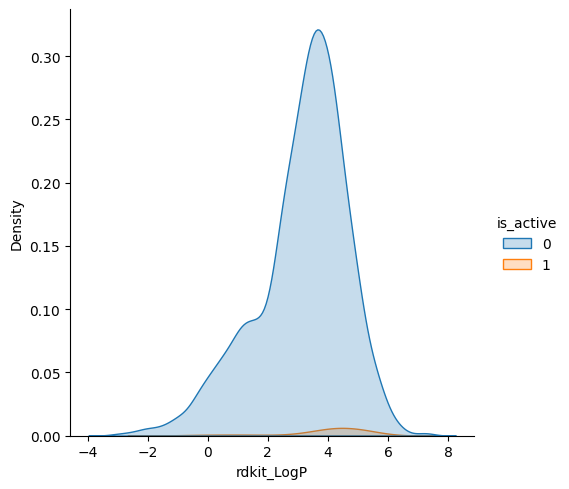

In [46]:
# Distribution plot for active vs non active molecules
# One can only use hue for a categorical variable like active vs non active (1 vs 0)
sns.displot(df, x="rdkit_LogP", hue="is_active", kind="kde", fill=True)

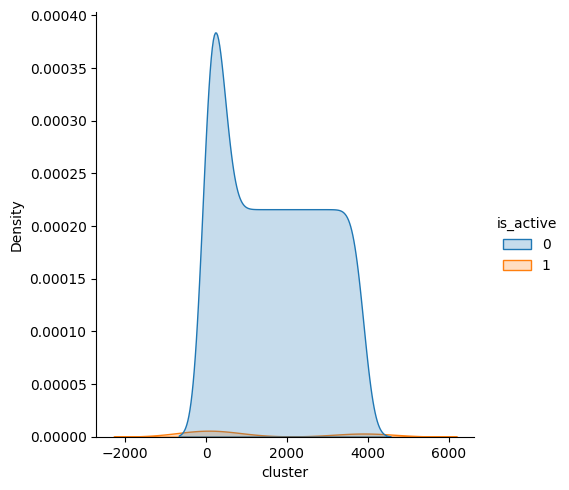

In [47]:
sns.displot(df, x="cluster", hue="is_active", kind="kde", fill=True)

In [48]:
# Sort df by cluster the logp
df = df.sort_values(by=["cluster", "rdkit_LogP"], ascending=[True, True])

mols2grid.display(df,
                  subset=["ID","img","cluster","is_active","rdkit_LogP"],
                  transform={"rdkit_LogP": lambda x: "{:.2f}".format(x)}, # Round to 2 decimals
                  n_cols=3,
                  size=(320,240))

MolGridWidget()

In [49]:
# Dropping duplicates to keep molecules with the lowest logP for each cluster
# This could be useful when proirtizing hits so that one has more space to optimize a molecule and not increase the logp over 5 (Rule of 5)
#Ensure that cluster is is sorted by the rdkit_logP value
df_unique = df.drop_duplicates("cluster")


mols2grid.display(df_unique,
                  subset=["ID","img","cluster","is_active","rdkit_LogP"],
                  transform={"rdkit_LogP": lambda x: "{:.2f}".format(x)}, # Round to 2 decimals
                  n_cols=3,
                  size=(320,240))

MolGridWidget()